# Covid no Estado do Ceará

https://www.youtube.com/watch?v=rckzwVBe7gk&t=3255s

In [1]:
# importando as bibliotecas necessárias

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
from folium import plugins
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot
import datetime as dt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

* Data from covid: https://brasil.io/home/
* Data of the cities: https://github.com/kelvins/Municipios-Brasileiros

In [2]:
data_covid = pd.read_csv('data/covid19.csv', parse_dates=True)
cities_lat_long = pd.read_csv('data/municipios.csv', parse_dates=True)

In [3]:
cities_lat_long.head(2)

,codigo_ibge,nome,latitude,longitude,capital,codigo_uf
0,5200050,Abadia de Goiás,-16.7573,-49.4412,0,52
1,3100104,Abadia dos Dourados,-18.4831,-47.3916,0,31


In [4]:
data_covid.head(2)

,epidemiological_week,date,order_for_place,state,city,city_ibge_code,place_type,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,new_confirmed,last_available_deaths,new_deaths,last_available_death_rate,estimated_population_2019,is_last,is_repeated
0,24,2020-06-08,43,CE,Abaiara,2300101.0,city,6,51.12039,0,1,0,0.1667,11737.0,True,False
1,24,2020-06-08,52,CE,Acarape,2300150.0,city,101,676.53560,0,6,0,0.0594,14929.0,True,False


In [5]:
data_covid['date'] = pd.to_datetime(data_covid['date']).dt.strftime("%Y-%m-%d")

In [6]:
data = data_covid.merge(cities_lat_long,
                        how = 'inner',
                        left_on='city_ibge_code', 
                        right_on='codigo_ibge')
data.columns

Index(['epidemiological_week', 'date', 'order_for_place', 'state', 'city',
       'city_ibge_code', 'place_type', 'last_available_confirmed',
       'last_available_confirmed_per_100k_inhabitants', 'new_confirmed',
       'last_available_deaths', 'new_deaths', 'last_available_death_rate',
       'estimated_population_2019', 'is_last', 'is_repeated', 'codigo_ibge',
       'nome', 'latitude', 'longitude', 'capital', 'codigo_uf'],
      dtype='object')

In [7]:
data.drop(['order_for_place', 'place_type', 'is_repeated', 'codigo_ibge', 'nome'], axis = 1, inplace=True)

In [8]:
data['city'].replace('Itapajé', 'Itapagé', inplace = True)

In [9]:
data.columns

Index(['epidemiological_week', 'date', 'state', 'city', 'city_ibge_code',
       'last_available_confirmed',
       'last_available_confirmed_per_100k_inhabitants', 'new_confirmed',
       'last_available_deaths', 'new_deaths', 'last_available_death_rate',
       'estimated_population_2019', 'is_last', 'latitude', 'longitude',
       'capital', 'codigo_uf'],
      dtype='object')

Abaixo eu crio um DataFrame com o código do iBGE e a respectiva cidade, e em seguida eu junto com os dados anteriores.
Fiz isso porque ao tentar plotar as informações o gráfico ficava todo preto, porque por algum motivo o Código do IGE do arquivo Json e do DataFrame fornecido pelo brasil.io não eram iguais. 

No arquivo Json o Código do IBGE é uma string, e por mais que eu convertesse os valores do DataFrame pra string ainda assim aparentemente eles não eram iguais(mesmo eu claramente vendo que eram iguais). Comprovei isso ao tentar fazer inner join nos dois datasets pelo Código do IBGE e o retorno era um DataFrame vazio. Quando tentei fazer o mesmo com as cidades o resultado funcionou.

Então decidi fazer inner join com os nomes das cidades e excluir a coluna do Código do IBGE do DataFrame inicial, e a partir de então utilizar o Código do IBGE que extraí do arquivo Json, que funcionou.

Outros pontos que foram corrigidos:
* O município do Itapagé está escrito como 'Itapajé' no data set do brasil.io ;
* O município do granjeiro não tem casos confirmados, entao no dataset que peguei do Brasil IO não cosnta as informações da Cidade;

In [10]:
import json

ce_cities = json.load(open('data/geojs-23-mun.json'))

id_cidade = []
nome_cidade = []

for i in range(len(ce_cities['features'])):
    Id = ce_cities['features'][i]['properties']['id']
    id_cidade.append(Id)
    nome = ce_cities['features'][i]['properties']['name']
    nome_cidade.append(nome)

ce = pd.DataFrame({'ibge_code': id_cidade, 'city': nome_cidade})

In [11]:
data = data.merge(ce, how = 'outer').drop('city_ibge_code', axis = 1)

# Mapa Confirmados

* Geodata Ceará on: https://github.com/tbrugz/geodata-br

In [12]:
columns = ['ibge_code', 'city', 'latitude', 'longitude', 'last_available_deaths', 'last_available_confirmed','last_available_confirmed_per_100k_inhabitants']
current_data = data[data['is_last'].fillna(True)][columns].fillna(0)

In [13]:
ceara = folium.Map( width= '100%',
                   tiles='Mapbox Bright',
                    height = '100%',
                    location = [-5.15, -39.5],
                   zoom_control=False,
                   min_zoom=7, max_zoom=9,
                   min_lat=-2.15, max_lat=-8.15, 
                   min_lon=-37, max_lon=-42, 
                   max_bounds=True,
                   zoom_start = 7)

In [14]:
folium.Choropleth(geo_data = ce_cities,
                  name = 'Casos Confirmados',
                  data = current_data,
                  columns = ['ibge_code' ,'last_available_confirmed_per_100k_inhabitants'],
                  key_on = 'feature.properties.id', 
                  fill_color = 'YlOrRd',
                  fill_opacity = 0.6,
                  line_color = 'black',
                  line_opacity = 1,
                  line_weight=0.25,
                  legend_name = 'Confirmed cases per 100k hab.',
                  tooltip =  'test',
                  show = True,
                 ).add_to(ceara)


In [15]:
for i in range(len(current_data)):
    folium.Circle(
        location=[current_data.iloc[i]['latitude'], current_data.iloc[i]['longitude']],
        color = 'gray',
        fill = 'gray',
        tooltip =
        '<meta http-equiv="content-type" content="text/html; charset=UTF-8" /><ul><li><bold>Cidade: </bold>'+ str(current_data.iloc[i]['city'])+'</li>'+
        '<li><bold>Casos Confirmados: </bold>'+ str(current_data.iloc[i]['last_available_confirmed'])+'</li>'+
        '<li><bold>Obitos Confirmados: </bold>'+ str(current_data.iloc[i]['last_available_deaths'])+'</li></ul>',
        radius = 1000
    ).add_to(ceara)

In [16]:
ceara

In [17]:
attr = ('&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> '
        'contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>')
tiles = 'http://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png'

ceara_heatmap = folium.Map( width= '100%',
                   tiles=tiles,
                    attr = attr,
                    height = '100%',
                    location = [-5.15, -39.5],
                   zoom_control=False,
                   min_zoom=7, max_zoom=12,
                   min_lat=-2.15, max_lat=-8.15, 
                   min_lon=-37, max_lon=-42, 
                   max_bounds=True,
                    zoom_start = 7)

In [18]:
columns = ['latitude', 'longitude', 'last_available_confirmed']
ceara_heatmap = ceara_heatmap.add_child(plugins.HeatMap(current_data[columns]))

In [19]:
for i in range(len(current_data)):
    folium.Circle(
        location=[current_data.iloc[i]['latitude'], current_data.iloc[i]['longitude']],
        color = '#00D611',
        fill = '#3EE02A',
        tooltip =
        '<ul><li><bold>Cidade: </bold>'+ str(current_data.iloc[i]['city'])+'</li>'+
        '<li><bold>Casos Confirmados: </bold>'+ str(current_data.iloc[i]['last_available_confirmed'])+'</li></ul>',
        radius = 1000
    ).add_to(ceara_heatmap)

In [20]:
ceara_heatmap

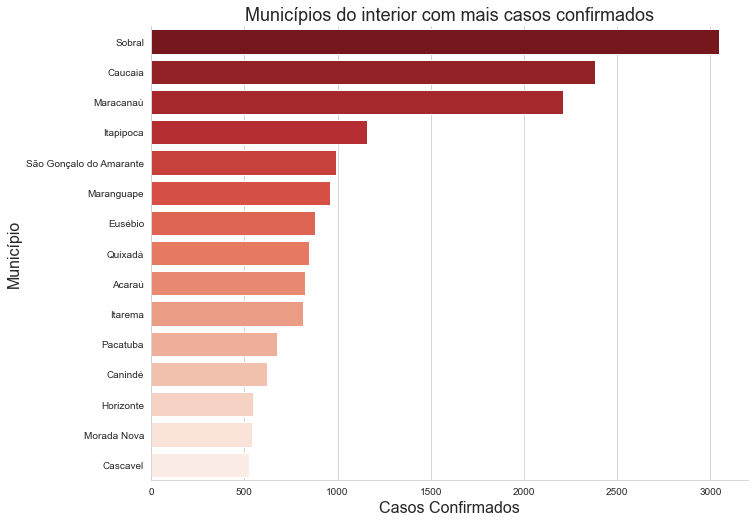

In [43]:
df = current_data.sort_values(by='last_available_confirmed', ascending = False)
sns.set_style("whitegrid")
g = sns.catplot(x = 'last_available_confirmed' ,y = 'city', data=df.iloc[1:16, [1,5]], kind = 'bar',  palette="Reds_r", height=7, aspect=1.5)
g.ax.set_title("Municípios do interior com mais casos confirmados",fontdict={'size':18})
g.ax.xaxis.set_label_text("Casos Confirmados",fontdict= {'size':16})
g.ax.yaxis.set_label_text("Município",fontdict= {'size':16})
plt.show()

In [72]:
trace = go.Bar(x = df.iloc[1:20].sort_values(by = 'last_available_confirmed').last_available_confirmed,
               y = df.iloc[1:20].sort_values(by = 'last_available_confirmed').city,
              orientation='h',
              name = 'Casos Confirmados',
               showlegend = True,
               marker = dict(color = 'rgba(255, 51, 51, 0.9)',
                             line=dict(color='rgb(35, 32, 33)', width=1.5)),
               hoverinfo = 'x')

fig = go.Figure(data = trace)
iplot(fig)

In [22]:
g.savefig('images/casos_interior.png')

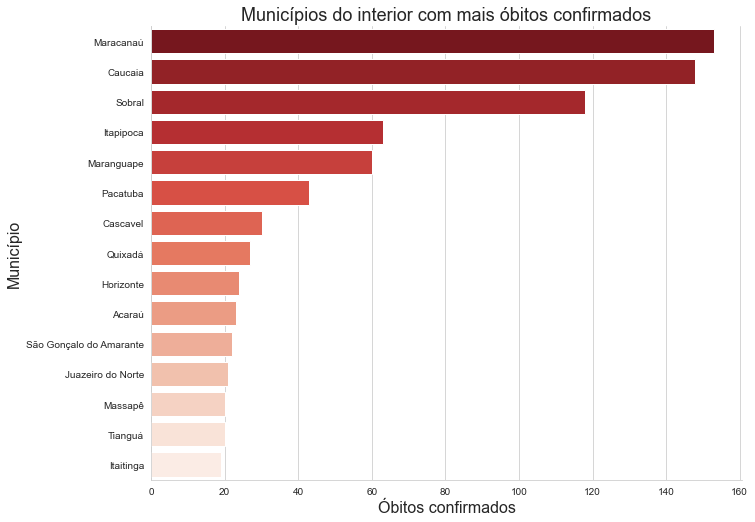

In [66]:
df = current_data.sort_values(by='last_available_deaths', ascending = False)

sns.set_style("whitegrid")
g = sns.catplot(x = 'last_available_deaths', y = 'city', data=df.iloc[1:16, [1,4]], kind = 'bar',  palette="Reds_r", height=7, aspect=1.5)
g.ax.set_title("Municípios do interior com mais óbitos confirmados",fontdict={'size':18})
g.ax.xaxis.set_label_text("Óbitos confirmados",fontdict= {'size':16})
g.ax.yaxis.set_label_text("Município",fontdict= {'size':16})
g.savefig('images/casos_interior.png')
plt.show()

In [73]:
trace = go.Bar(x = df.iloc[1:20].sort_values(by='last_available_deaths').last_available_deaths,
               y = df.iloc[1:20].sort_values(by='last_available_deaths').city,
               orientation='h',
               name = 'Casos Confirmados',
               showlegend = True,
               marker = dict(color = 'rgba(255, 51, 51, 0.9)',
                             line=dict(color='rgb(35, 32, 33)', width=1.5)),
               hoverinfo = 'x')

fig = go.Figure(data = trace)
iplot(fig)

In [24]:
df.head()

,ibge_code,city,latitude,longitude,last_available_deaths,last_available_confirmed,last_available_confirmed_per_100k_inhabitants
2954,2304400,Fortaleza,-3.71664,-38.5423,2459.0,27320.0,1023.47320
5412,2307650,Maracanaú,-3.86699,-38.6259,153.0,2210.0,969.78314
2143,2303709,Caucaia,-3.72797,-38.6619,148.0,2383.0,659.38019
8506,2312908,Sobral,-3.68913,-40.3482,118.0,3047.0,1458.34829
4557,2306405,Itapipoca,-3.49933,-39.5836,63.0,1158.0,895.19009


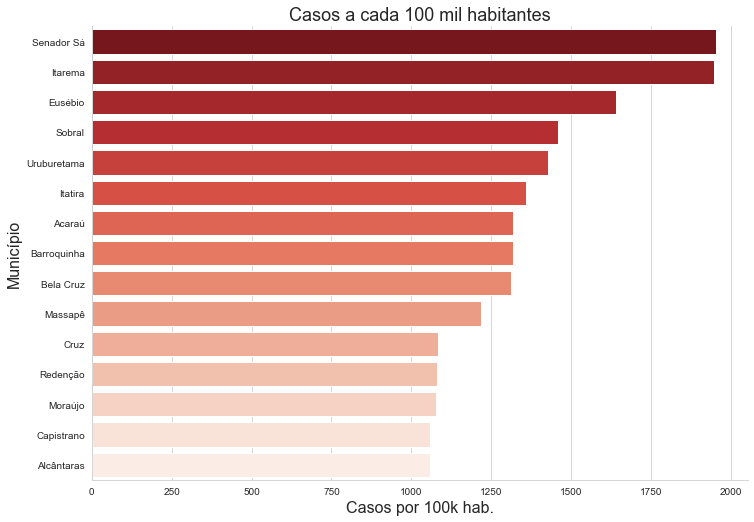

In [25]:
df = current_data.sort_values(by='last_available_confirmed_per_100k_inhabitants', ascending = False)

sns.set_style("whitegrid")
g = sns.catplot(x = 'last_available_confirmed_per_100k_inhabitants', y = 'city', data=df.iloc[1:16, [1,6]], kind = 'bar',  palette="Reds_r", height=7, aspect=1.5)
g.ax.set_title("Casos a cada 100 mil habitantes",fontdict={'size':18})
g.ax.xaxis.set_label_text("Casos por 100k hab.",fontdict= {'size':16})
g.ax.yaxis.set_label_text("Município",fontdict= {'size':16})
g.savefig('images/casos_interior.png')
plt.show()

In [ ]:
trace = go.Bar(x = df.iloc[1:20].sort_values(by='last_available_deaths').last_available_deaths,
               y = df.iloc[1:20].sort_values(by='last_available_deaths').city,
               orientation='h',
               name = 'Casos Confirmados',
               showlegend = True,
               marker = dict(color = 'rgba(255, 51, 51, 0.9)',
                             line=dict(color='rgb(35, 32, 33)', width=1.5)),
               hoverinfo = 'x')

fig = go.Figure(data = trace)
iplot(fig)

In [27]:
df.head()

,ibge_code,city,latitude,longitude,last_available_deaths,last_available_confirmed,last_available_confirmed_per_100k_inhabitants
8219,2312403,São Gonçalo do Amarante,-3.60515,-38.9726,22.0,993.0,2050.72075
8446,2312809,Senador Sá,-3.35305,-40.4662,1.0,149.0,1954.61105
4678,2306553,Itarema,-2.92480,-39.9167,12.0,814.0,1946.15789
2759,2304285,Eusébio,-3.89250,-38.4559,16.0,879.0,1639.37484
8506,2312908,Sobral,-3.68913,-40.3482,118.0,3047.0,1458.34829


In [26]:
ceara.save('maps/ceara_cases_per_100k_hab.html')
ceara_heatmap.save('maps/ceara_heatmap.html')